In [655]:
'''
Import the packages needed for classification
'''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
import seaborn as sns
from scipy.ndimage import rotate
from sklearn.decomposition import PCA
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from matplotlib import rcParams
import pandas as pd
plt.close()

In [28]:
# MAC USERS TAKE NOTE:
# For clearer plots in Jupyter notebooks on macs, run the following line of code:
%config InlineBackend.figure_format = 'retina'
rcParams['font.size']=12
rcParams['figure.figsize']=(10, 6)

In [2]:
'''
Set directory parameters
'''
# Set the directories for the data and the CSV files that contain ids/labels
dir_train_images  = './training/'
dir_test_images   = './testing/'
dir_train_labels  = './labels_training.csv'
dir_test_ids      = './sample_submission.csv'

In [3]:
'''
Include the functions used for loading, preprocessing, features extraction, 
classification, and performance evaluation
'''

def load_data(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids

In [702]:
# Load the data
data, labels = load_data(dir_train_images, dir_train_labels, training=True)

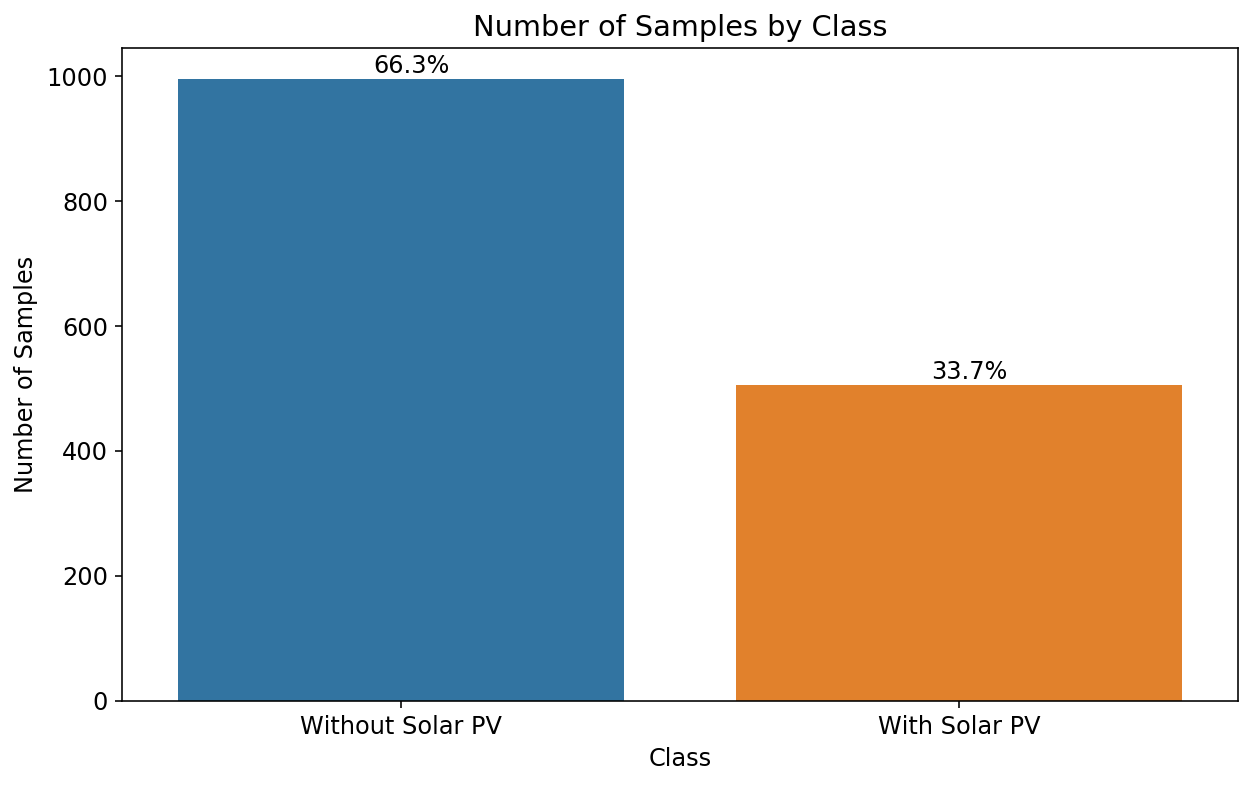

In [821]:
# Check balance of classes
ax_q2 = sns.countplot(labels)
plt.title("Number of Samples by Class")
plt.xlabel("Class")
plt.xticks(np.arange(2), ("Without Solar PV", "With Solar PV"))
plt.ylabel("Number of Samples")

for p in ax_q2.patches:
        ax_q2.annotate('{:.1%}'.format(p.get_height()/1500), (p.get_x()+0.35, p.get_height()+10))
plt.savefig('class_sample.png')

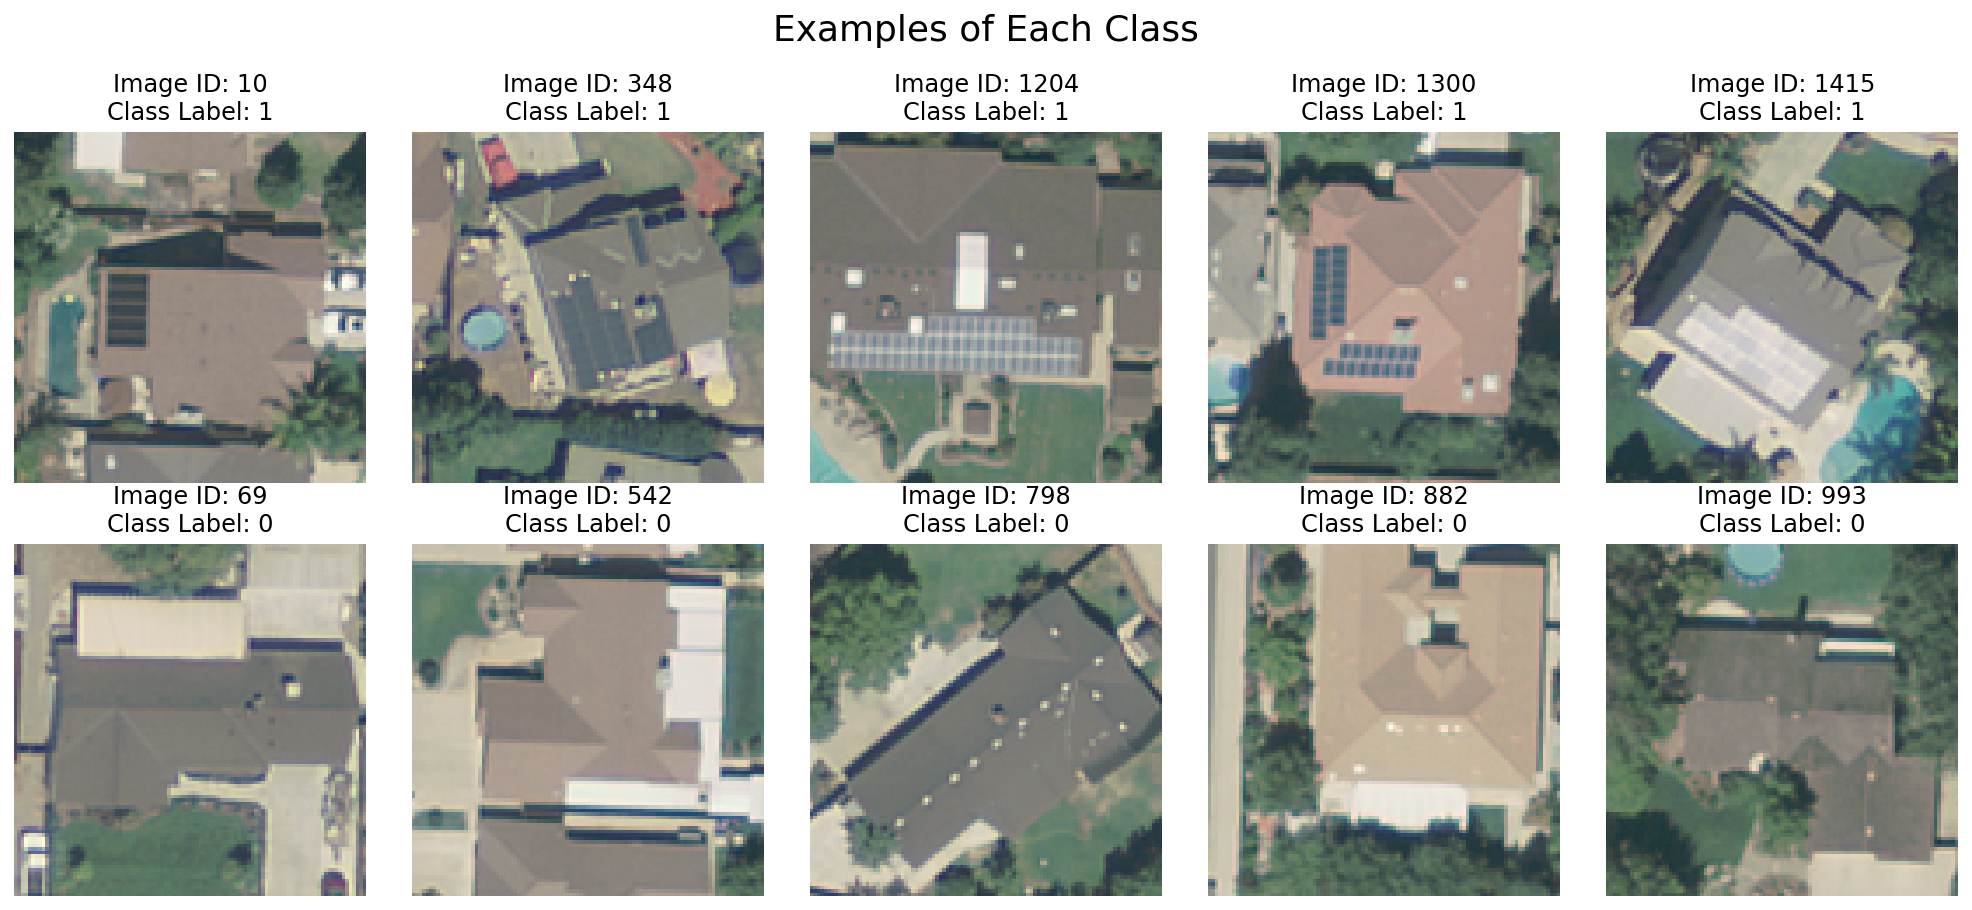

In [724]:
# Sample images of each class
fig, ax = plt.subplots(2, 5, figsize=(14, 6))
class_0 = np.arange(0,1500)[labels == 0]
class_1 = np.arange(0,1500)[labels == 1]
data_0_sample = np.sort(np.random.choice(class_0, 5))
data_1_sample = np.sort(np.append(np.random.choice(class_1, 4), 1415))
for i in range(5):
    index = data_1_sample[i]
    image = data[index]
    ax[0, i].imshow(image)
    ax[0, i].axis("off")
    ax[0, i].set_title("Image ID: {}\nClass Label: {}"\
                      .format(index, labels[index]), fontsize=12)
for i in range(5):
    index = data_0_sample[i]
    image = data[index]
    ax[1, i].imshow(image)
    ax[1, i].axis("off")
    ax[1, i].set_title("Image ID: {}\nClass Label: {}"\
                      .format(index, labels[index]), fontsize=12)
fig.suptitle("Examples of Each Class", fontsize=18, y=1.05)
plt.tight_layout()
fig.savefig('class_examples.png')

In [269]:
# Preprocessing: Greyscale, round down to nearest 20 + Feature Extraction: HOG
def preprocess_and_extract_features(data):
    hog_images = []
    hog_features = []
    data = np.mean(data, axis=3) - np.mean(data, axis=3) % 20
    data_list = [data[i] for i in range(data.shape[0])]
    for image in data_list:
        fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(4, 4), visualize=True)
        hog_images.append(hog_image)
        hog_features.append(fd)
    features = np.array(hog_features)
    return features, hog_images

In [803]:
# Extract HOG images
_ , hog_images = preprocess_and_extract_features(data)

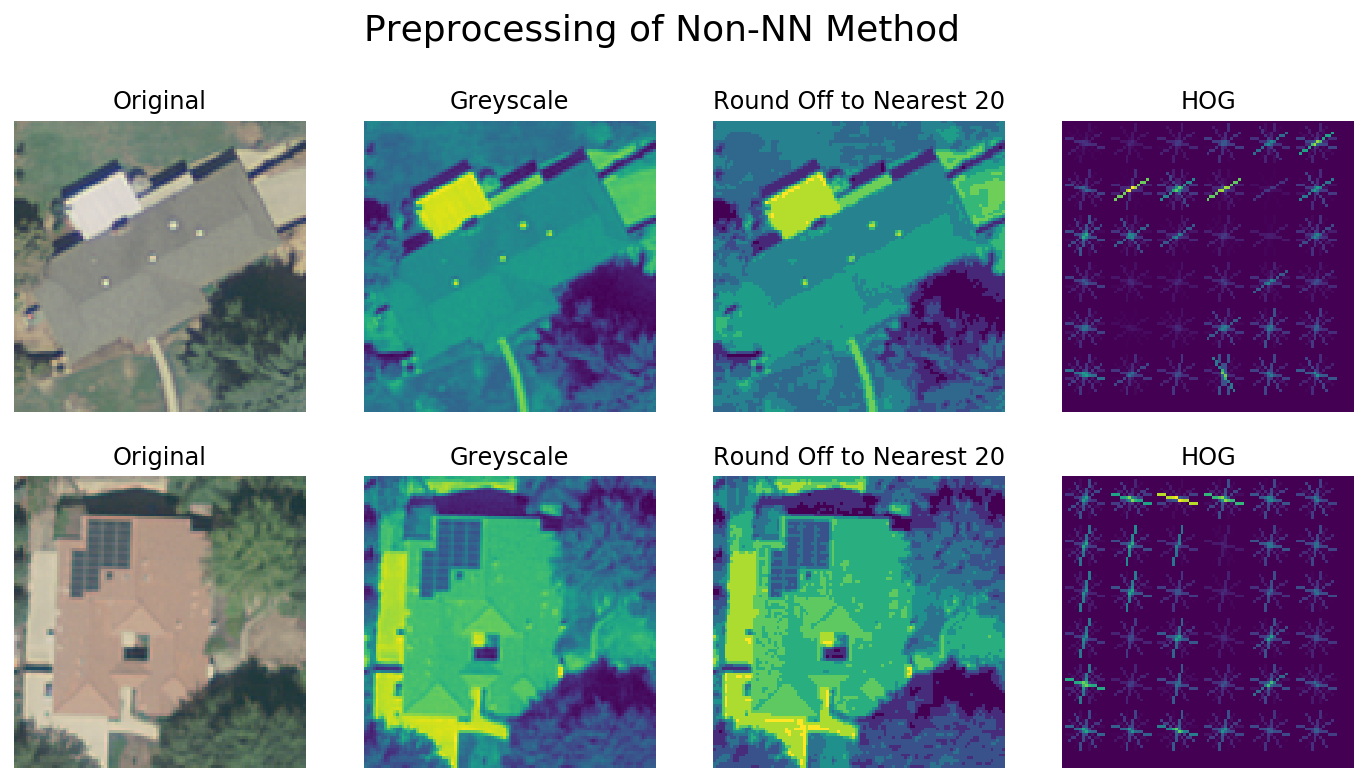

In [802]:
# Visualize the preprocessing steps
fig, ax = plt.subplots(2, 4, figsize=(12, 6))
class_0 = np.arange(0,1500)[labels == 0]
class_1 = np.arange(0,1500)[labels == 1]
data_0_sample = np.sort(np.random.choice(class_0, 1))
data_1_sample = np.sort(np.random.choice(class_1, 1))

index = data_0_sample[0]
image = data[index]
image_grey = image.mean(axis=2)
image_grey_20 = image_grey - image_grey % 20
image_hog = hog_images[index]
ax[0, 0].imshow(image)
ax[0, 0].axis("off")
ax[0, 0].set_title("Original", fontsize=12)
ax[0, 1].imshow(image_grey)
ax[0, 1].axis("off")
ax[0, 1].set_title("Greyscale", fontsize=12)
ax[0, 2].imshow(image_grey_20)
ax[0, 2].axis("off")
ax[0, 2].set_title("Round Off to Nearest 20", fontsize=12)
ax[0, 3].imshow(image_hog)
ax[0, 3].axis("off")
ax[0, 3].set_title("HOG", fontsize=12)

index = data_1_sample[0]
image = data[index]
image_grey = image.mean(axis=2)
image_grey_20 = image_grey - image_grey % 20
image_hog = hog_images[index]
ax[1, 0].imshow(image)
ax[1, 0].axis("off")
ax[1, 0].set_title("Original", fontsize=12)
ax[1, 1].imshow(image_grey)
ax[1, 1].axis("off")
ax[1, 1].set_title("Greyscale", fontsize=12)
ax[1, 2].imshow(image_grey_20)
ax[1, 2].axis("off")
ax[1, 2].set_title("Round Off to Nearest 20", fontsize=12)
ax[1, 3].imshow(image_hog)
ax[1, 3].axis("off")
ax[1, 3].set_title("HOG", fontsize=12)

fig.suptitle("Preprocessing of Non-NN Method", fontsize=18, y=1)
#plt.tight_layout()
fig.savefig('non_nn_preprocessing.png')

In [772]:
# Model: SVM
def set_classifier(c):
    '''Shared function to select the classifier for both performance evaluation
    and testing
    '''
    return SVC(C=c, gamma='scale', probability=True)

In [49]:
# Cross-validation on training data
def cv_performance_assessment(X,y,k,clf):
    '''Cross validated performance assessment
    
    X   = training data
    y   = training labels
    k   = number of folds for cross validation
    clf = classifier to use
    
    Divide the training data into k folds of training and validation data. 
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are 
    aggregated and output
    '''
    # Establish the k folds
    prediction_scores = np.empty(y.shape[0],dtype='object')
    prediction_labels = np.empty(y.shape[0],dtype='object')
    
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        X_train, X_val   = X[train_index], X[val_index]
        y_train          = y[train_index]
        
        # Train the classifier
        X_train_features, _ = preprocess_and_extract_features(X_train)
        clf              = clf.fit(X_train_features,y_train)
        
        # Test the classifier on the validation data for this fold
        X_val_features, _   = preprocess_and_extract_features(X_val)
        cpred      = clf.predict_proba(X_val_features)
        
        # Save the predictions for this fold
        prediction_scores[val_index] = cpred[:,1]
    return prediction_scores

In [126]:
# Function for plot ROC curves
def plot_roc(labels, prediction_scores):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot(fpr, tpr, label=legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()

def plot_add_chance(start=[0,1], end=[0,1]):
    plt.plot(start,end,'--', color='gray', label='Chance')
    plt.legend()
    plt.tight_layout()

In [120]:
# Function for plot precision recall curves
def plot_pr(y, prediction_scores):
    precision, recall, _ = metrics.precision_recall_curve(y, prediction_scores, pos_label=1)
    auc = metrics.auc(recall, precision)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot(recall, precision, label=legend_string)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()

In [53]:
# Cross Validation performance for different Hyperparameter C of SVM
'''
Sample script for cross validated performance
'''
# Set parameters for the analysis
num_training_folds = 5

C = [0.001, 0.01, 0.1, 1, 10, 100]
pred = []
auc_list = []
fscore = []
for c in C:
    # Choose which classifier to use
    clf = set_classifier(c)
    
    # Perform cross validated performance assessment
    prediction_scores= cv_performance_assessment(data,labels,num_training_folds,clf)
    pred.append(prediction_scores)
    auc_list.append(metrics.roc_auc_score(labels, prediction_scores))
    fscore.append(metrics.f1_score(labels, np.where(prediction_scores>=0.5, 1, 0)))
    print("C = {}: AUC = {:.4f}, F-1 Score = {:.4f}".format(c, auc_list[-1], fscore[-1]))

C = 0.001: AUC = 0.7940, F-1 Score = 0.6152
C = 0.01: AUC = 0.7938, F-1 Score = 0.6191
C = 0.1: AUC = 0.7982, F-1 Score = 0.6134
C = 1: AUC = 0.8224, F-1 Score = 0.6326
C = 10: AUC = 0.8230, F-1 Score = 0.6404
C = 100: AUC = 0.8202, F-1 Score = 0.6443


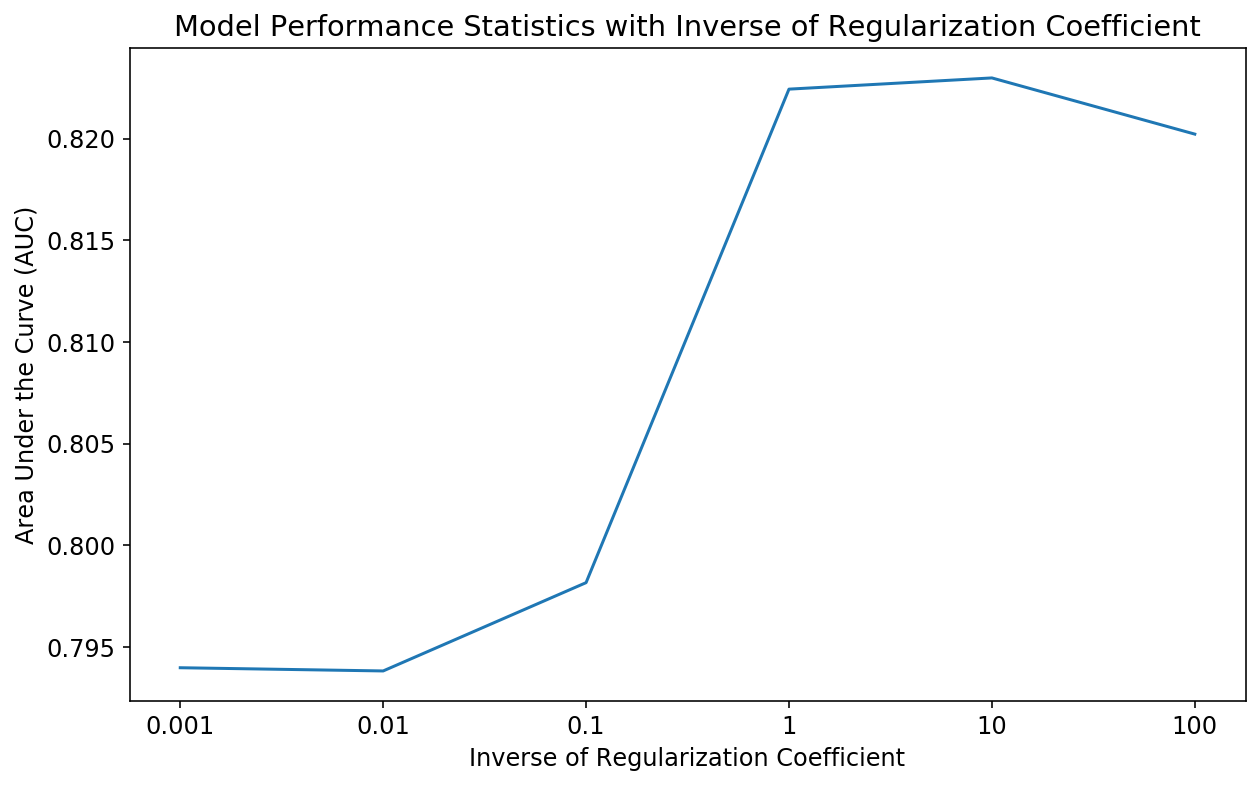

In [457]:
# Plot of AUC of SVM against different C
C_str = [str(c) for c in C]
plt.plot(C_str, auc_list)
plt.xlabel('Inverse of Regularization Coefficient')
plt.ylabel('Area Under the Curve (AUC)')
plt.title("Model Performance Statistics with Inverse of Regularization Coefficient");
plt.savefig('svm_c.png', bbox_inches = "tight")

In [192]:
# Load prediction scores for CNN
cnn = np.genfromtxt('output2.csv',delimiter=',', skip_header = 1, usecols=(1, 2, 3))
cnn_labels = cnn[:, 0].astype(int)
cnn_prediction_labels = cnn[:, 1].astype(int)
cnn_prediction_scores = cnn[:, 2]

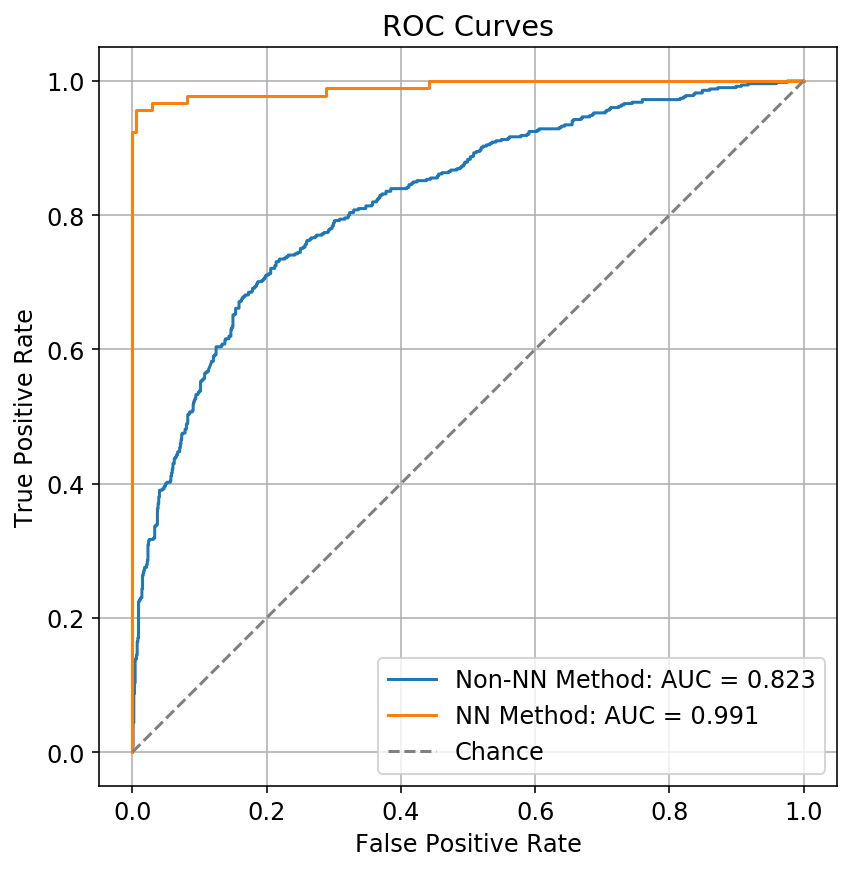

In [455]:
# Plot ROC curves for both methods
plot_roc(labels, pred[4])
plot_roc(cnn_labels, cnn_prediction_scores)
plot_add_chance()
L=plt.legend()
L.get_texts()[0].set_text('Non-NN Method: ' + L.get_texts()[0].get_text())
L.get_texts()[1].set_text('NN Method: ' + L.get_texts()[1].get_text())
plt.title("ROC Curves")
plt.savefig('roc_curve.png', bbox_inches = "tight")

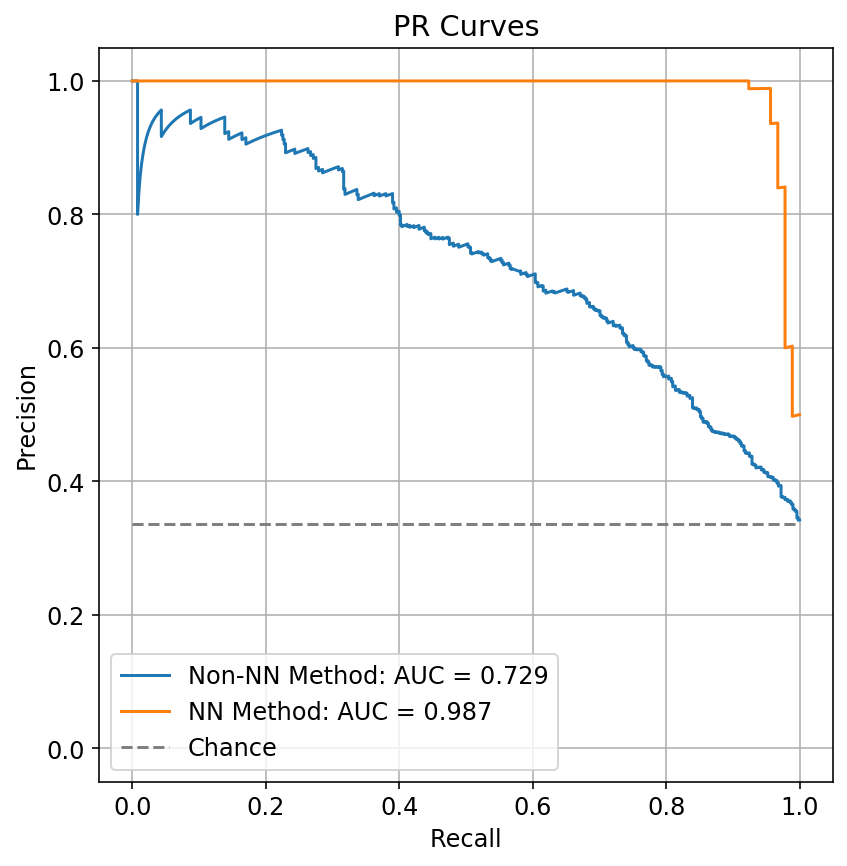

In [668]:
# Plot PR curves for both methods
plot_pr(labels, pred[4])
plot_pr(cnn_labels, cnn_prediction_scores)
pos_prop = len(labels[labels==1])/len(labels)
plot_add_chance(start=[0,1], end=[pos_prop,pos_prop])
plt.ylim(-0.05, 1.05)
L=plt.legend()
L.get_texts()[0].set_text('Non-NN Method: ' + L.get_texts()[0].get_text())
L.get_texts()[1].set_text('NN Method: ' + L.get_texts()[1].get_text())
plt.title("PR Curves")
plt.savefig('pr_curve.png', bbox_inches = "tight")

In [687]:
# Confusion Matrix of Non-NN
conf_mat = metrics.confusion_matrix(labels, np.where(pred[4]>=0.5, 1, 0))
conf_mat = conf_mat/conf_mat.sum(axis=1)[:, None]

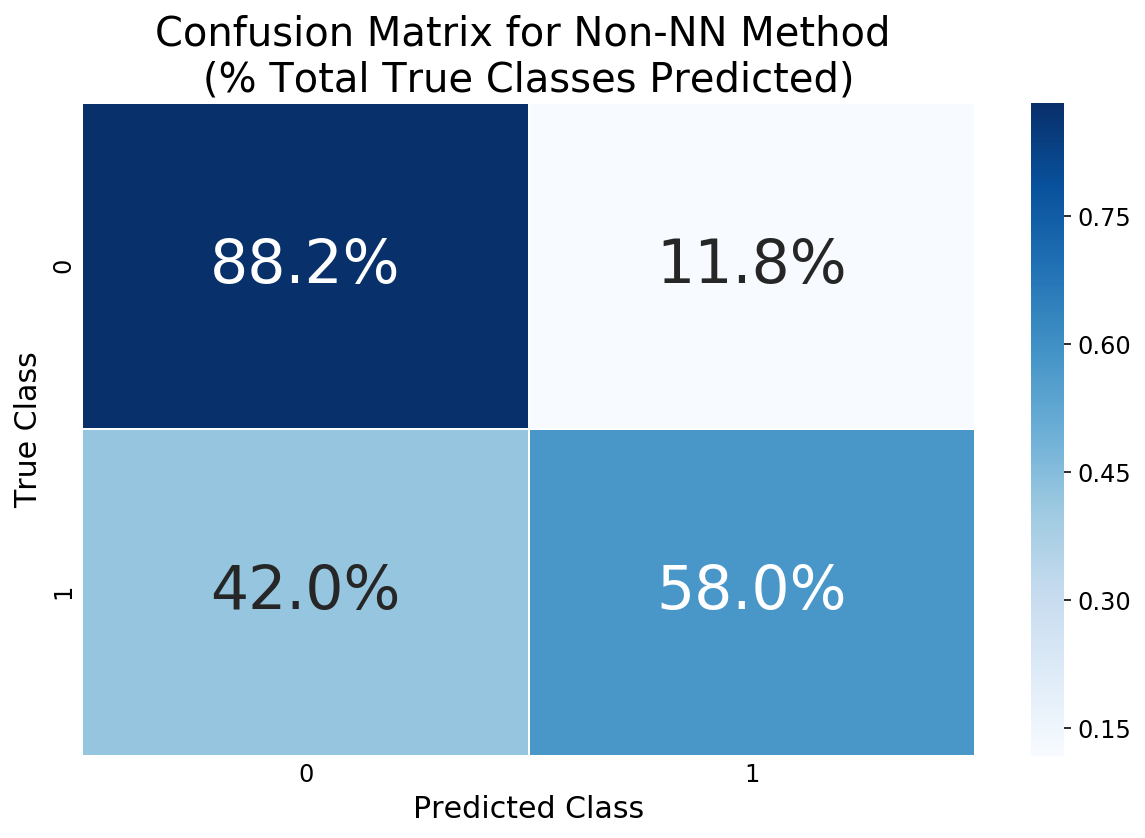

In [688]:
# Plot Confusion Matrix Heatmap
conf_mat_heatmap = sns.heatmap(conf_mat, annot=True, \
                               linewidths=.5, cmap="Blues", fmt='.1%', annot_kws={"size": 30})
conf_mat_heatmap.set_xticklabels(conf_mat_heatmap.get_xticklabels())
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
conf_mat_heatmap.tick_params(axis='both', which='both', length=0)
plt.title("Confusion Matrix for Non-NN Method \n(% Total True Classes Predicted)", fontsize=20)
plt.xlabel("Predicted Class", fontsize=15)
plt.ylabel("True Class", fontsize=15)
plt.savefig('non_nn_conf.png')

In [689]:
# Confusion Matrix
conf_mat = metrics.confusion_matrix(cnn_labels, np.where(cnn_prediction_scores>=0.5, 1, 0))
conf_mat = conf_mat/conf_mat.sum(axis=1)[:, None]

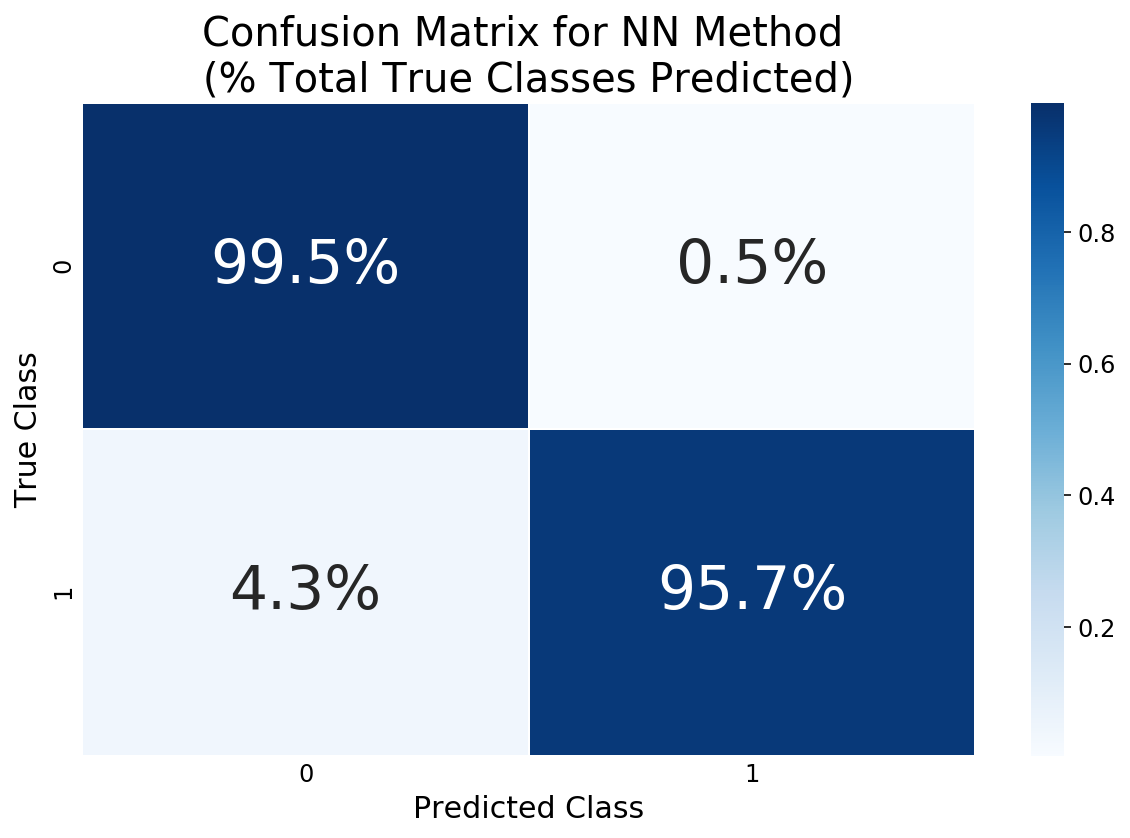

In [690]:
# Plot Confusion Matrix Heatmap
conf_mat_heatmap = sns.heatmap(conf_mat, annot=True, \
                               linewidths=.5, cmap="Blues", fmt='.1%', annot_kws={"size": 30})
conf_mat_heatmap.set_xticklabels(conf_mat_heatmap.get_xticklabels())
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
conf_mat_heatmap.tick_params(axis='both', which='both', length=0)
plt.title("Confusion Matrix for NN Method \n(% Total True Classes Predicted)", fontsize=20)
plt.xlabel("Predicted Class", fontsize=15)
plt.ylabel("True Class", fontsize=15)
plt.savefig('nn_conf.png')

In [364]:
# Mis-classifications of Non-NN
data_svm_fn = np.arange(0,1500)[labels > np.where(pred[4]>=0.5, 1, 0)]
data_svm_fp = np.arange(0,1500)[labels < np.where(pred[4]>=0.5, 1, 0)]

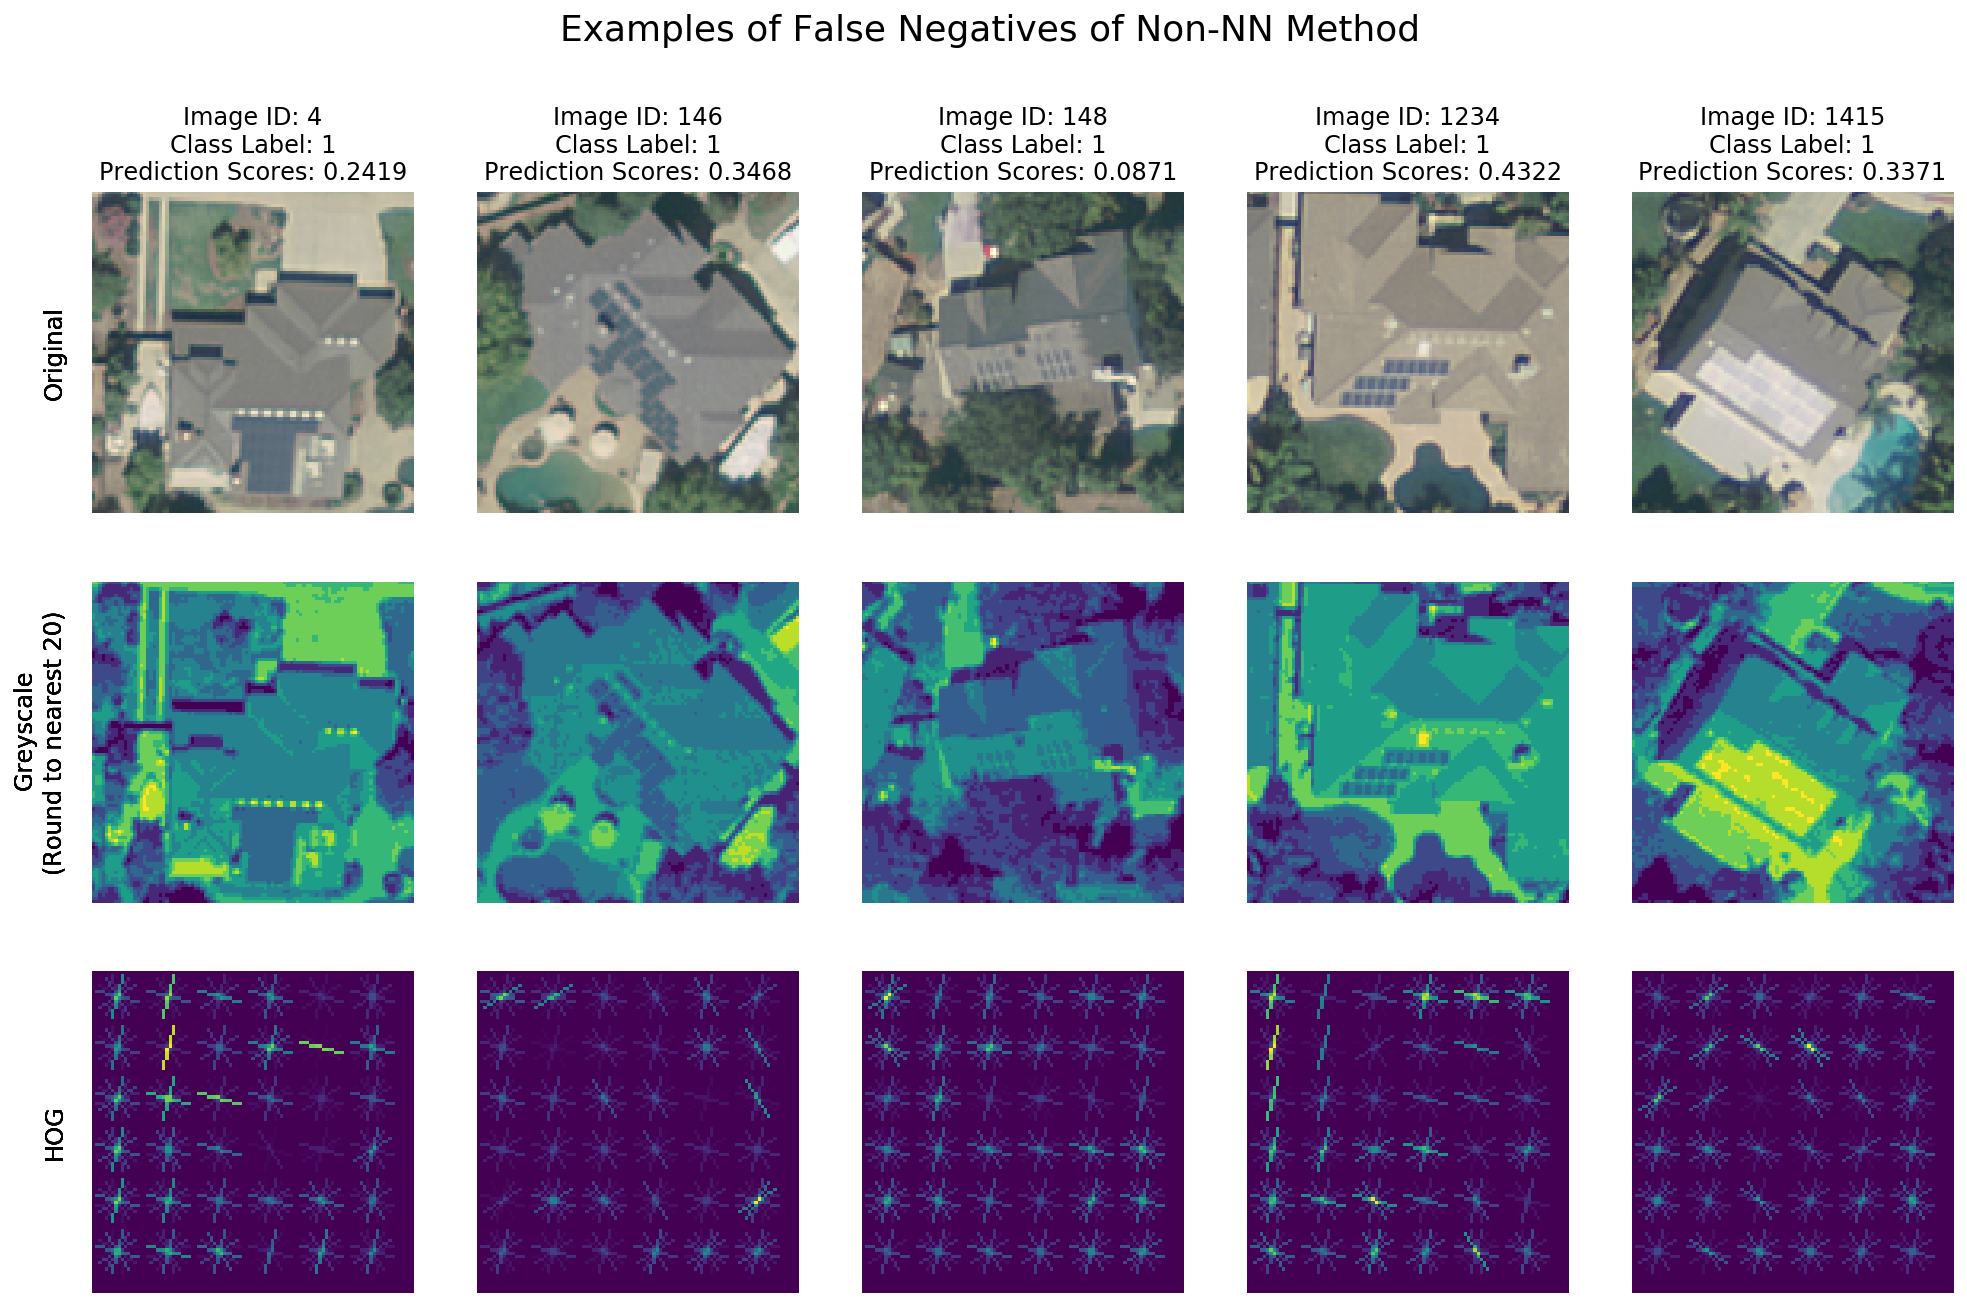

In [369]:
# False Negatives of Non-NN Method
fig, ax = plt.subplots(3, 5, figsize=(14, 9))
data_svm_fn_sample = np.sort(np.append(np.random.choice(data_svm_fn, 3), (1234, 1415)))
for i in range(5):
    index = data_svm_fn_sample[i]
    image = data[index]
    image_grey = image.mean(axis=2) - image.mean(axis=2) % 20
    image_hog = hog_images[index]
    ax[0,i].imshow(image)
    ax[0,i].axis("off")
    ax[1,i].imshow(image_grey)
    ax[1,i].axis("off")
    ax[2,i].imshow(image_hog)
    ax[2,i].axis("off")
    ax[0, 0].annotate("Original\n", xy=(0, 50), ha='right', va='center', rotation=90)
    ax[1, 0].annotate("Greyscale        \n(Round to nearest 20)\n", xy=(0, 50), ha='right', va='center', rotation=90)
    ax[2, 0].annotate("HOG\n", xy=(0, 50), ha='right', va='center', rotation=90)
    ax[0,i].set_title("Image ID: {}\nClass Label: {}\nPrediction Scores: {:.4f}"\
                      .format(index, labels[index], pred[4][index]), fontsize=12)
fig.suptitle("Examples of False Negatives of Non-NN Method", fontsize=18, y=1.03)
plt.tight_layout()
fig.savefig('non_nn_fn.png')

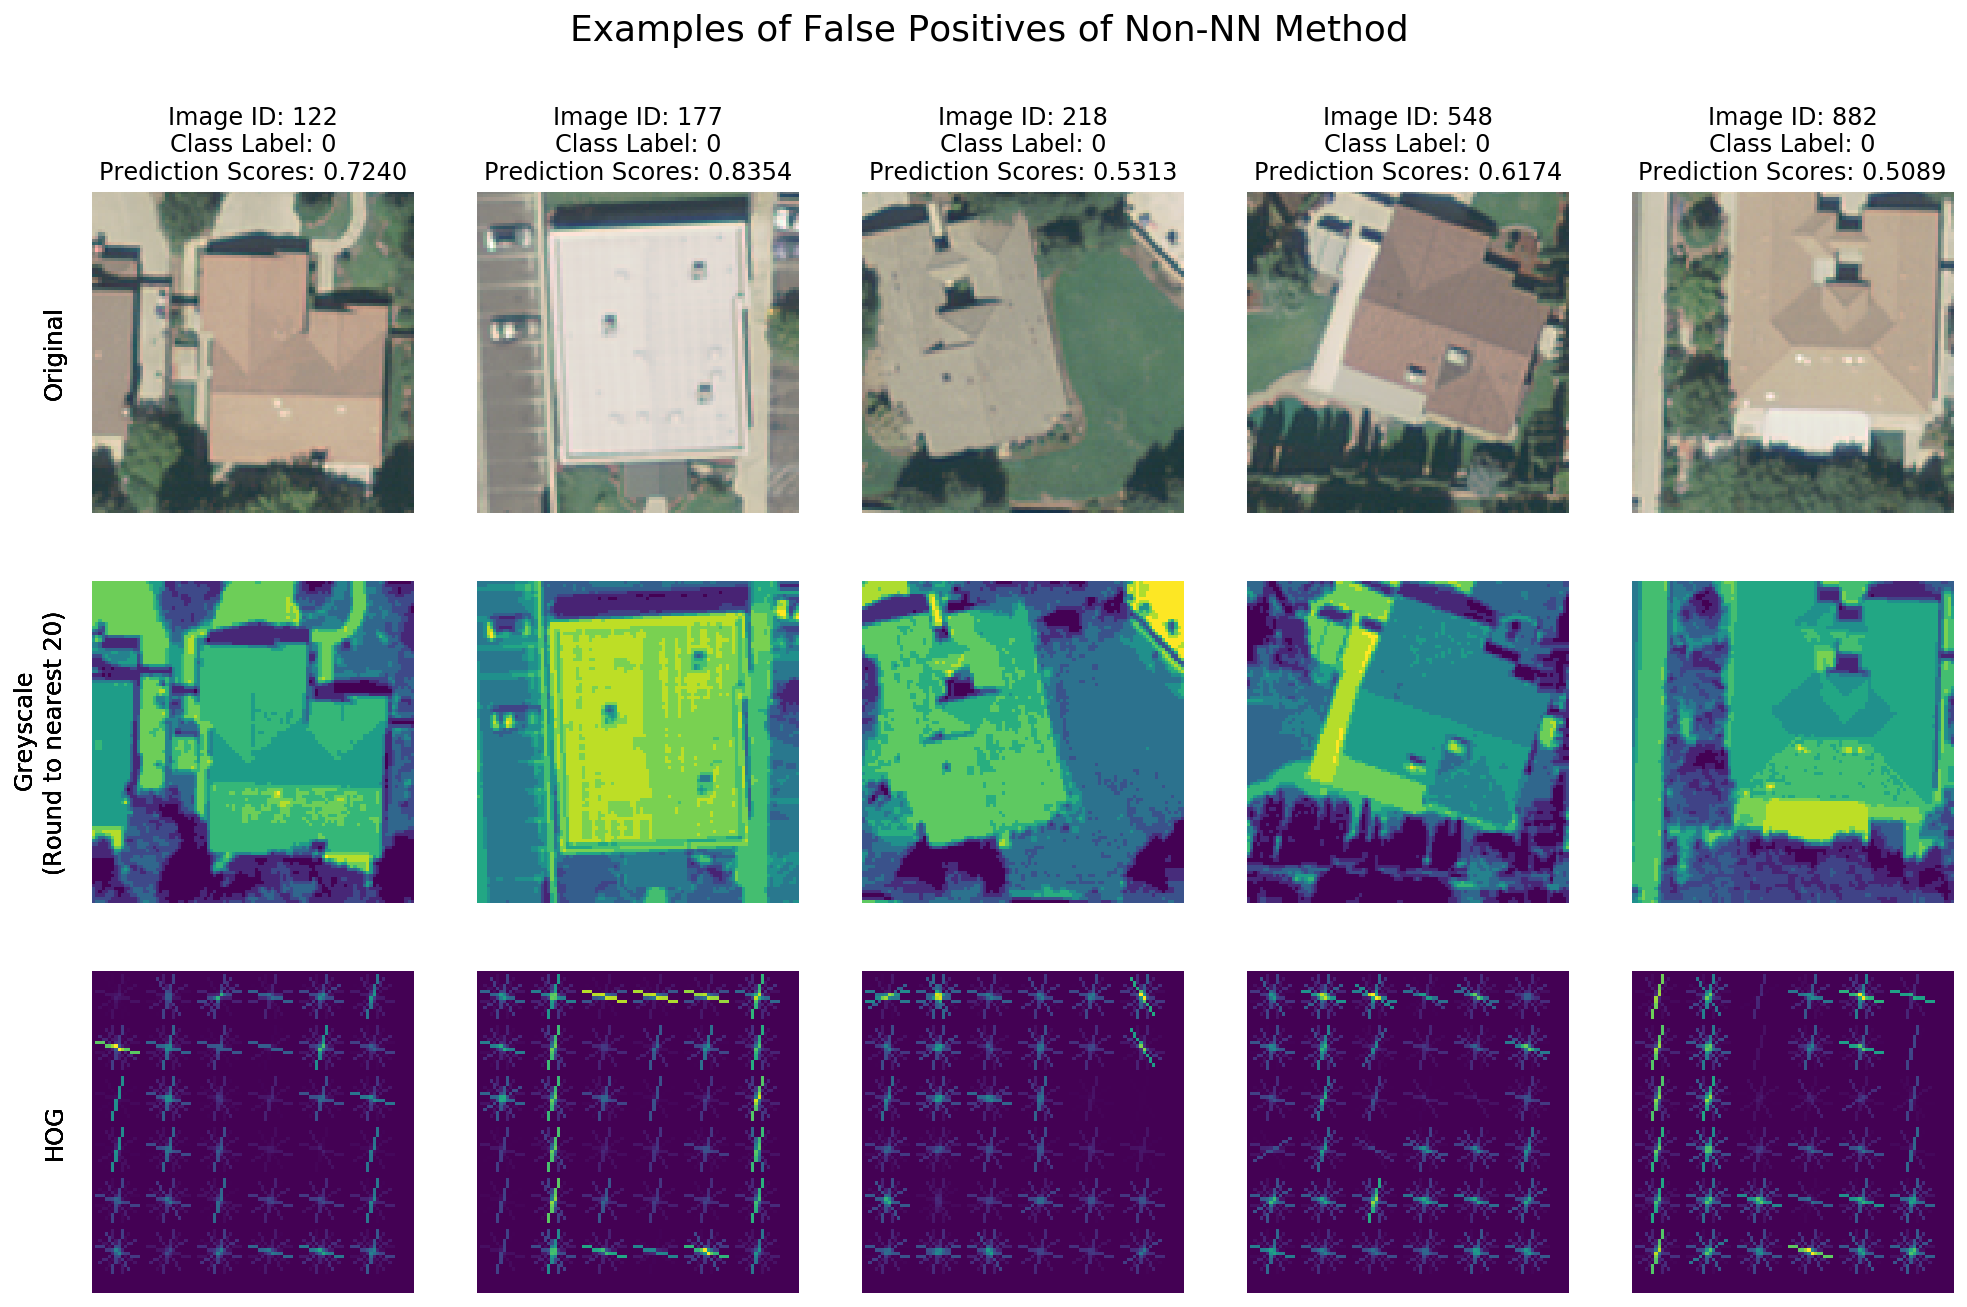

In [370]:
# False Positives of Non-NN Method
fig, ax = plt.subplots(3, 5, figsize=(14, 9))
data_svm_fp_sample = np.sort(np.random.choice(data_svm_fp, 5))
for i in range(5):
    index = data_svm_fp_sample[i]
    image = data[index]
    image_grey = image.mean(axis=2) - image.mean(axis=2) % 20
    image_hog = hog_images[index]
    ax[0,i].imshow(image)
    ax[0,i].axis("off")
    ax[1,i].imshow(image_grey)
    ax[1,i].axis("off")
    ax[2,i].imshow(image_hog)
    ax[2,i].axis("off")
    ax[0, 0].annotate("Original\n", xy=(0, 50), ha='right', va='center', rotation=90)
    ax[1, 0].annotate("Greyscale        \n(Round to nearest 20)\n", xy=(0, 50), ha='right', va='center', rotation=90)
    ax[2, 0].annotate("HOG\n", xy=(0, 50), ha='right', va='center', rotation=90)
    ax[0,i].set_title("Image ID: {}\nClass Label: {}\nPrediction Scores: {:.4f}"\
                      .format(index, labels[index], pred[4][index]), fontsize=12)
fig.suptitle("Examples of False Positives of Non-NN Method", fontsize=18, y=1.03)
plt.tight_layout()
fig.savefig('non_nn_fp.png');

In [569]:
# Non-NN False Negatives Correctly Classified by NN
tp_nn_fn_non_nn = np.genfromtxt('output3.csv',delimiter=',', skip_header = 1, usecols=(1, 2))
tp_nn_fn_non_nn_sample = np.random.choice(np.arange(tp_nn_fn_non_nn.shape[0]), 4, replace=False)
tp_nn_fn_non_nn_sample_image = tp_nn_fn_non_nn[tp_nn_fn_non_nn_sample, 0].astype(int)
tp_nn_fn_non_nn_sample_pred = tp_nn_fn_non_nn[tp_nn_fn_non_nn_sample, 1]

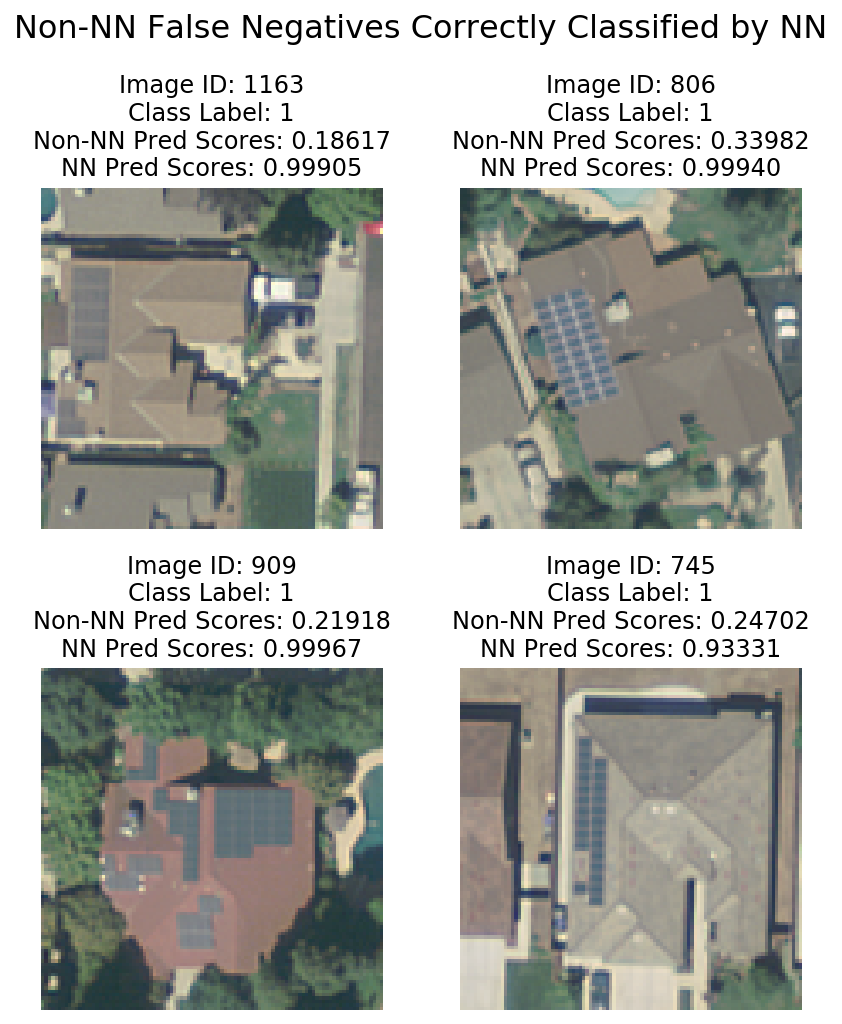

In [599]:
# Non-NN False Negatives Correctly Classified by NN
fig, ax = plt.subplots(2, 2, figsize=(6, 7))
for i in range(2):
    for j in range(2):
        index = tp_nn_fn_non_nn_sample_image.reshape(2,2)[i,j]
        image = data[index]
        ax[i,j].imshow(image)
        ax[i,j].axis("off")
        ax[i,j].set_title("Image ID: {}\nClass Label: {}\nNon-NN Pred Scores: {:.5f}\nNN Pred Scores: {:.5f}"\
                          .format(index, labels[index], pred[4][index], tp_nn_fn_non_nn_sample_pred.reshape(2,2)[i,j]), fontsize=12)
fig.suptitle("Non-NN False Negatives Correctly Classified by NN", fontsize=16, y=1.03)
plt.tight_layout()
fig.savefig('tp_nn_fn_non_nn.jpg')

In [595]:
# Non-NN False Positives Correctly Classified by NN
tn_nn_fp_non_nn = np.genfromtxt('output4.csv',delimiter=',', skip_header = 1, usecols=(1, 2))
tn_nn_fp_non_nn_sample = np.random.choice(np.arange(tn_nn_fp_non_nn.shape[0]), 4, replace=False)
tn_nn_fp_non_nn_sample_image = tn_nn_fp_non_nn[tn_nn_fp_non_nn_sample, 0].astype(int)
tn_nn_fp_non_nn_sample_pred = tn_nn_fp_non_nn[tn_nn_fp_non_nn_sample, 1]

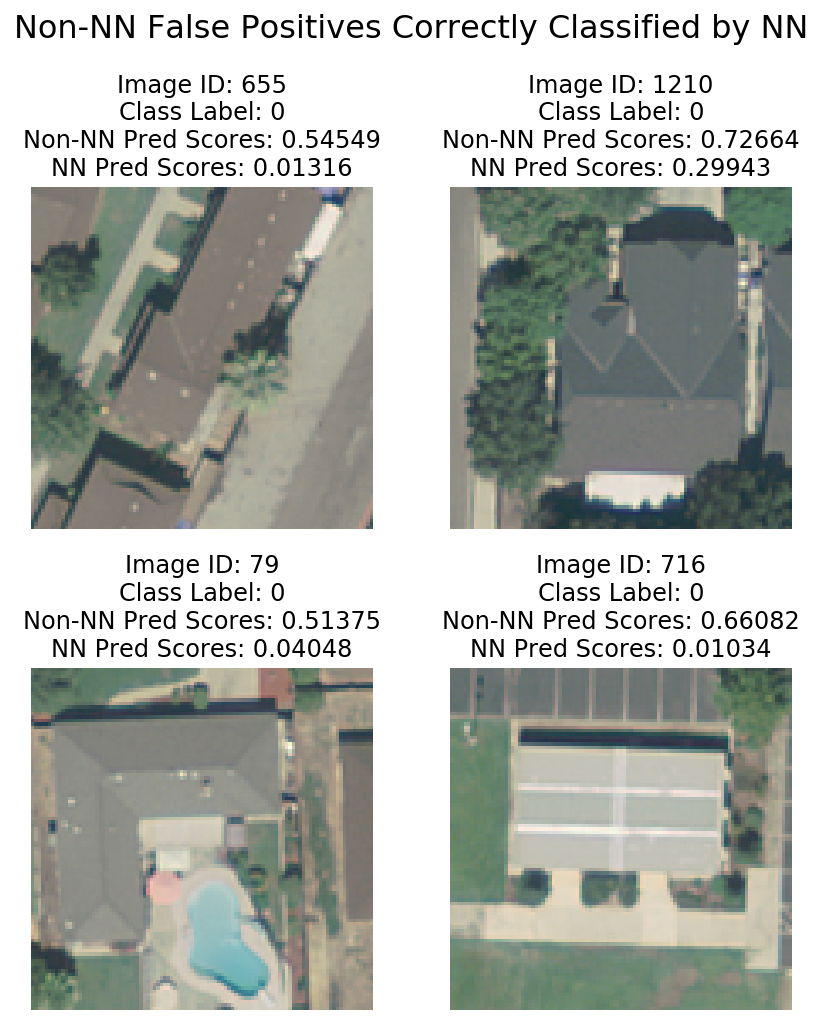

In [596]:
# Non-NN False Positives Correctly Classified by NN
fig, ax = plt.subplots(2, 2, figsize=(6, 7))
for i in range(2):
    for j in range(2):
        index = tn_nn_fp_non_nn_sample_image.reshape(2,2)[i,j]
        image = data[index]
        ax[i,j].imshow(image)
        ax[i,j].axis("off")
        ax[i,j].set_title("Image ID: {}\nClass Label: {}\nNon-NN Pred Scores: {:.5f}\nNN Pred Scores: {:.5f}"\
                          .format(index, labels[index], pred[4][index], tn_nn_fp_non_nn_sample_pred.reshape(2,2)[i,j]), fontsize=12)
fig.suptitle("Non-NN False Positives Correctly Classified by NN", fontsize=16, y=1.03)
plt.tight_layout()
fig.savefig('tn_nn_fp_non_nn.png');

In [601]:
# Mis-classification fo NN
fn_nn_image = np.array([383, 385, 1380, 1234])
fp_nn_image = np.array([802])
fn_nn_pred = np.array([0.22551899, 0.115549155, 0.07734009, 0.36983678])
fp_nn_pred = np.array([0.87824416])

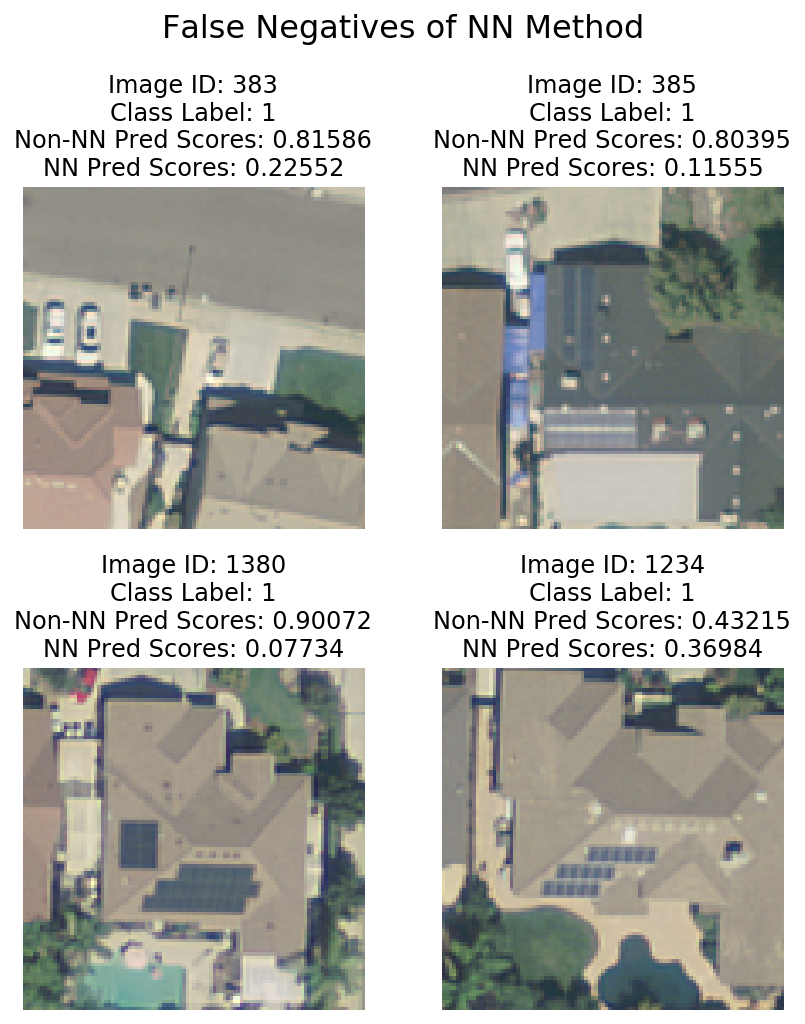

In [617]:
# False Negatives of NN Method
fig, ax = plt.subplots(2, 2, figsize=(6, 7))
for i in range(2):
    for j in range(2):
        index = fn_nn_image.reshape(2,2)[i,j]
        image = data[index]
        ax[i,j].imshow(image)
        ax[i,j].axis("off")
        ax[i,j].set_title("Image ID: {}\nClass Label: {}\nNon-NN Pred Scores: {:.5f}\nNN Pred Scores: {:.5f}"\
                          .format(index, labels[index], pred[4][index], fn_nn_pred.reshape(2,2)[i,j]), fontsize=12)
fig.suptitle("False Negatives of NN Method", fontsize=16, y=1.03)
plt.tight_layout()
fig.savefig('fn_nn.jpg')

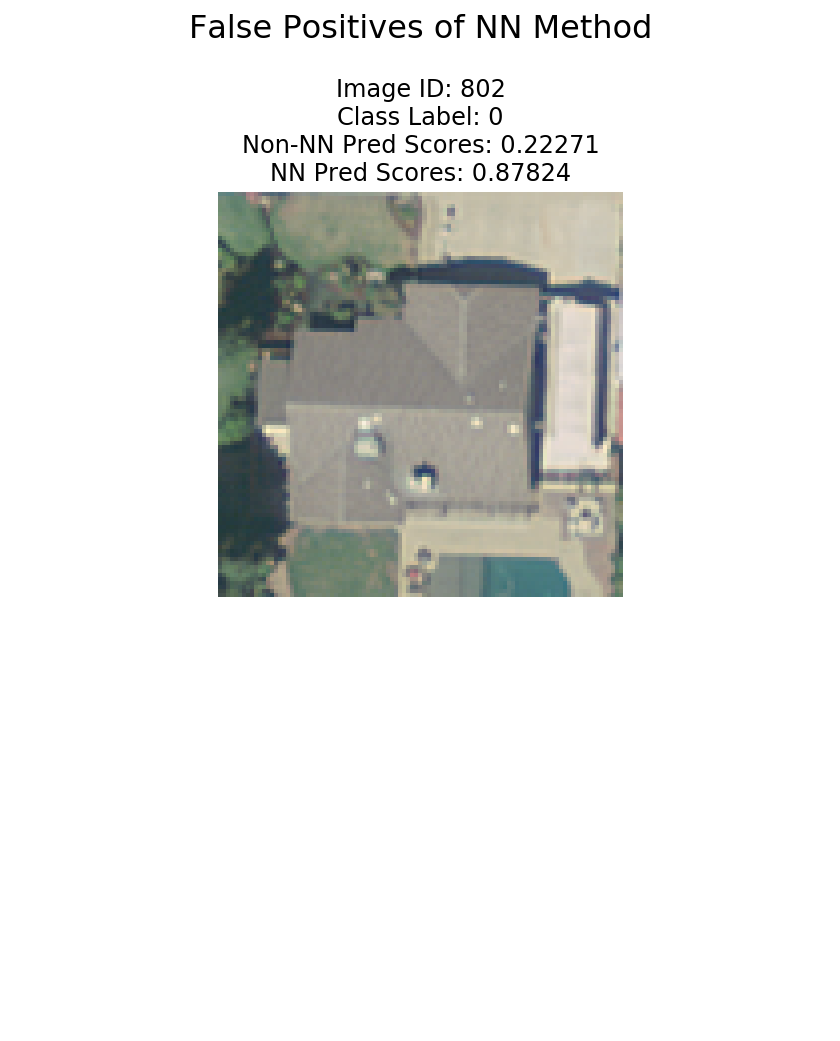

In [615]:
# False Positives of NN Method
fig, ax = plt.subplots(2, 1, figsize=(6, 7))
index = fp_nn_image[0]
image = data[index]
ax[0].imshow(image)
ax[0].axis("off")
ax[0].set_title("Image ID: {}\nClass Label: {}\nNon-NN Pred Scores: {:.5f}\nNN Pred Scores: {:.5f}"\
                  .format(index, labels[index], pred[4][index], fp_nn_pred[0]), fontsize=12)
ax[1].axis('off')
fig.suptitle("False Positives of NN Method", fontsize=16, y=1.03)
plt.tight_layout()
fig.savefig('fp_nn.jpg')

In [629]:
# Performance Metrics of Non-NN
non_nn_accuracy = metrics.accuracy_score(labels, np.where(pred[4]>=0.5, 1, 0))
non_nn_precision = metrics.precision_score(labels, np.where(pred[4]>=0.5, 1, 0))
non_nn_recall = metrics.recall_score(labels, np.where(pred[4]>=0.5, 1, 0))
non_nn_auc = metrics.roc_auc_score(labels, pred[4])
non_nn_metric = np.array([non_nn_accuracy, non_nn_precision, non_nn_recall, non_nn_auc])

In [630]:
# Performance Metrics of NN
nn_accuracy = metrics.accuracy_score(cnn_labels, np.where(cnn_prediction_scores>=0.5, 1, 0))
nn_precision = metrics.precision_score(cnn_labels, np.where(cnn_prediction_scores>=0.5, 1, 0))
nn_recall = metrics.recall_score(cnn_labels, np.where(cnn_prediction_scores>=0.5, 1, 0))
nn_auc = metrics.roc_auc_score(cnn_labels, cnn_prediction_scores)
nn_metric = np.array([nn_accuracy, nn_precision, nn_recall, nn_auc])

In [653]:
# Performance Metrics Table
pd.options.display.float_format = '{:,.4f}'.format
model_metrics = pd.DataFrame(np.c_[non_nn_metric, nn_metric], columns=['Non-NN Method', 'NN Method'], index=['Accuracy', 'Precision', 'Recall', 'AUC'])

In [654]:
model_metrics

,Non-NN Method,NN Method
Accuracy,0.7807,0.9833
Precision,0.7146,0.9888
Recall,0.5802,0.9565
AUC,0.8230,0.9907
